# MU4MA077, Base d'analyse de donnée, 2024-2025
# Les K-plus proches voisins

<div style="text-align: right"> 
Sorbonne Université, Master 1
</div>

<div style="text-align: right"> 
Merci à Ons Jelassi, Pavlo Mozharovskyi et aux autres collègues dont j'ai pu m'inspirer pour construire ce TP
</div>

# Table of contents
1. [Premier pas, les K-plus proches voisins sur des données simulées](#part1)
    - [Génération articielle de données](#part1sec1)
    - [Classifieur de Bayes](#part1sec2)
    - [Implémentation du classifieur des K-plus proches voisins sur des données simulées](#part1sec3)
    - [Extension des K-plus proches voisins à un problème de régression](#part1sec4)
2. [Les K-plus proches voisins sur des données réelles (avec sklearn)](#part2)
    - [Les 1-plus proches voisins avec sklearn](#part2sec1)
    - [La cross validation par la méthode du leave one out](#part2sec2)
    - [Implementation accélérée avec une ACP](#part3sec1)
3. [Quelques exercices](#part3)
    - [Exercice 1](#part3sec1)
    - [Exercice 2](#part3sec2)
    - [Exercice 3](#part3sec3)

In [1]:
import numpy as np
import statistics
import seaborn as sns
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits

# Premier pas, les K-plus proches voisins sur des données simulées <a id="part1"></a>

Pour rappel, dans ce TP, nous nous placons dans le contexte de l'analyse supervisé. C'est à dire un contexte dans lequel on a:

- La distribution (ou loi) $\mathcal{D}$ est telle que $\text{Supp}(\mathcal{D}) = \mathcal{X}\times\mathcal{Y}$.
  
- Le jeu de données est de la forme $\mathbf{Z}=(z_1, \cdots,z_n)^T$ avec $z_1, \cdots,z_n \underset{\text{i.i.d.}}{\sim} \mathcal{D}$ et $z_i = (x_i, y_i)$, pour tout $i \in [n]$.
  
- On cherche à construire une fonction de prédiction (ou hypothèse) $h : \mathcal{X} \rightarrow \mathcal{Y}$ tel que $h(\mathcal{D}_{\mathcal{X}}) \underset{\text{en loi}}{\approx} \mathcal{D}_{\mathcal{Y}}$, 
    où $\mathcal{D}_{\mathcal{X}}$ et $\mathcal{D}_{\mathcal{Y}}$ sont les marginales de $\mathcal{D}$ sur $\mathcal{X}$ et $\mathcal{Y}$.

- $\mathcal{X}$ est appelé l'espace d'entrée et $\mathcal{Y}$ l'espace de sortie. 

En fonction de la forme de $\mathcal{Y}$, et de la manière dont on définit ``$\underset{\text{en loi}}{\approx}$'' on se retrouve soit dans un problème de régression, soit de classification. 

## Génération articielle de données <a id="part1sec1"></a>

On considère dans cette partie que les observations sont décrites en deux dimensions, pour pouvoir les visualiser facilement. Pour générer des données, on a créé trois fonction génératices ci-dessous: **rand_tri_gauss**, **rand_clown** et **rand_checkers**. 

In [2]:
def rand_tri_gauss(n, means, variances):
    d = len(means[0])
    data = np.zeros((n, d))
    labels = np.random.choice(3, size=n) 
    
    for i in range(3):
        indices = np.where(labels == i)
        data[indices] = np.random.multivariate_normal(means[i], np.diag(variances[i]), size=len(indices[0]))
    
    return data, labels

def rand_checkers(n):
    x = np.random.uniform(0, 2, size=n)
    y = np.random.uniform(0, 2, size=n)
    labels = (((x * 2) // 1 + (y * 2) // 1) % 2).astype(int)  # Augmenter le nombre de cases à 10x10
    
    X = np.vstack((x, y)).T
    return X, labels

def rand_clown(n, sigma2):
    x = np.random.uniform(-1, 1, size=n)
    y = x**2 + np.random.normal(0, np.sqrt(sigma2)/2, size=n)
    
    n_eyes = n // 10 
    eyes_x = np.hstack((np.random.normal(-0.5, 0.1, size=n_eyes), np.random.normal(0.5, 0.1, size=n_eyes)))
    eyes_y = np.hstack((np.random.normal(2, 0.1, size=n_eyes), np.random.normal(2, 0.1, size=n_eyes)))
    
    X = np.vstack((np.hstack((x, eyes_x)), np.hstack((y, eyes_y)))).T
    labels = np.hstack((np.zeros(n), np.ones(2 * n_eyes)))
    
    return X, labels

<b style="color:red"> À vous de jouer :</b> Étudiez les fonctions ci-dessus (sans les utiliser immédiatement, mais en les lisant). Que renvoient ces fonctions ? À quoi correspond la dernière colonne ? Sommes-nous dans un problème de régression ou de classification, à votre avis ? Pour chaque fonction, générez n=100 et n=1000 points et proposez une visualisation adaptée de ces ensembles de données (on posera les paramètres ``means = [[0, 0], [3, 3], [-3, 3]], variances = [[2, 2], [2, 2], [2, 2]]`` et ``sigma2= 0.1``). Commentez.

<b style="color:red"> Réponse :</b>  


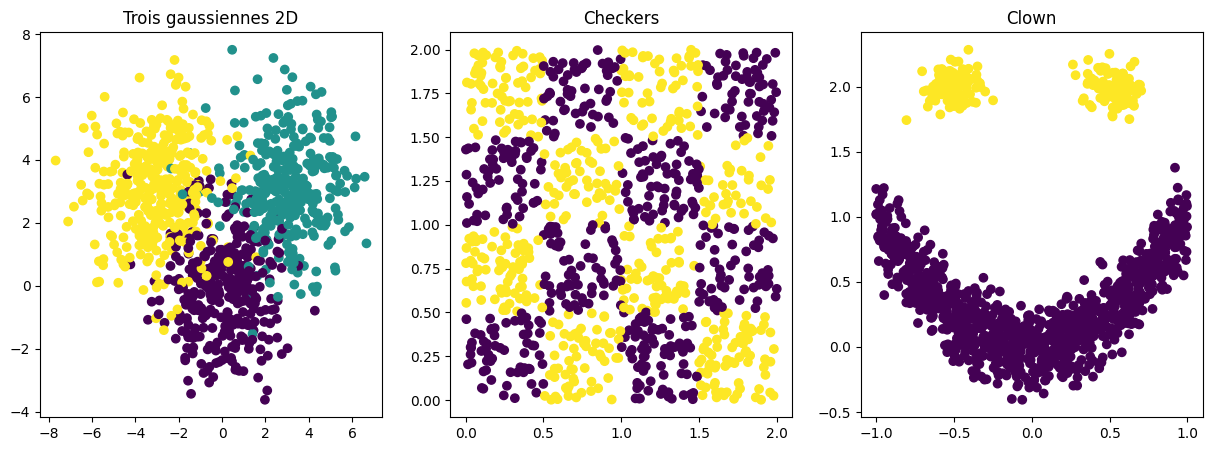

In [9]:
n = 1000
means = [[0, 0], [3, 3], [-3, 3]]
variances = [[2, 2], [2, 2], [2, 2]]
sigma2= 0.1

plt.figure(figsize=(15, 5))

data, labels = rand_tri_gauss(n, means, variances)
plt.subplot(1, 3, 1)
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title("Trois gaussiennes 2D")

data, labels = rand_checkers(n)
plt.subplot(1, 3, 2)
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title("Checkers")

data , labels = rand_clown(n, sigma2)
plt.subplot(1, 3, 3)
plt.scatter(data[:, 0], data[:, 1], c=labels)
plt.title("Clown")

plt.show()

## Classifieur de Bayes <a id="part1sec1"></a>
### On connait la loi sous-jacente des données $\mathcal{D}$

Maintentant que l'on connait la fonction génératrice des données, on peut en déduire le classifieru optimal de Bayes. Pour rappel, soit une distribution $\mathcal{D}$ telle que $\text{Supp}(\mathcal{D}) = \mathcal{X}\times\mathcal{Y}$ avec $\mathcal{Y}$ catégorielle. Soit un classifieur $h^{\text{opt}}: \mathcal{X} \rightarrow \mathcal{Y}$ tel que

$h^{\text{opt}}(x) \in \text{argmax}_{ k \in \mathcal{Y}} ~~~\mathbb{P}_{y \sim \mathcal{D}_{\mathcal{Y} \mid x}} \left [ y =k \right ],$ pour tout $x \in \mathcal{X}$.

Alors $h^{\text{opt}}$ minimise l'erreur de classification théorique sur $\mathcal{D}$. 

<b style="color:red"> À vous de jouer :</b>  Déduisez et tracez le classifieur optimal de Bayes pour les données issues des processus de générations ci-dessus. On vous donne la réponse pour le cas du damier (cas facile car déterministe)



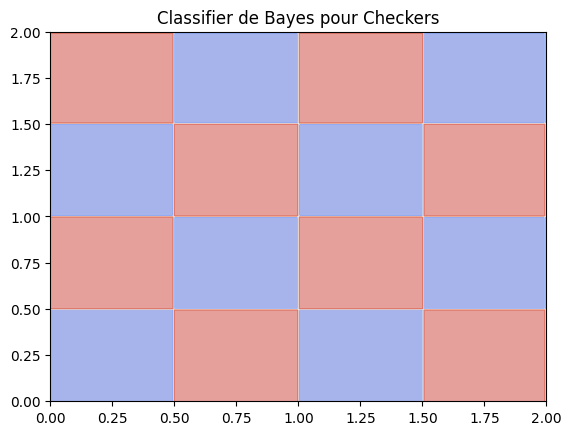

In [ ]:

#Création d'une grille
x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
xx, yy = np.meshgrid(x, y)

# Calcul de la périodicté du damier pour connaitre la classe
labels = (((xx * 2) // 1 + (yy * 2) // 1) % 2).astype(int)

# Plotting
plt.contourf(xx, yy, labels, cmap='coolwarm', alpha=0.5)
plt.title("Classifier de Bayes pour Checkers")
plt.show()

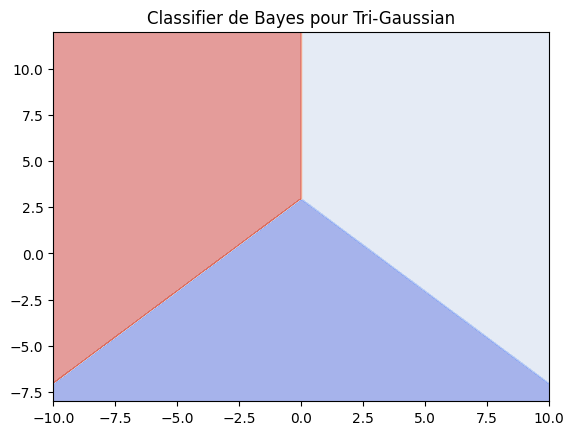

In [13]:
# Compléter les __hole__ pour les deux autres échantillons

#Paramètres des Gaussiennes
means = [[0, 0], [3, 3], [-3, 3]]
variances = [[2, 2], [2, 2], [2, 2]]

#Création d'une grille
x_min, x_max = -10, 10
y_min, y_max = -8, 12
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid = []
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        grid.append([xx[i, j], yy[i, j]])
grid = np.array(grid)

# Récupération des valeurs des densité en chaque point de la grille
scores = np.zeros((grid.shape[0], 3))
for i in range(3):
    scores[:, i] = multivariate_normal.pdf(grid, mean=means[i], cov=np.diag(variances[i]))


# Evaluation de la densité maximum
labels = np.argmax(scores, axis=1)
labels = labels.reshape(xx.shape)

# Plotting
plt.contourf(xx, yy, labels, alpha=0.5, cmap='coolwarm')
plt.title("Classifier de Bayes pour Tri-Gaussian")
plt.show()

In [ ]:
# Bonus : faire de même à partir de 0 pour le dernier mélange

sigma2 = 0.1
# Densité de probabilité des yeux de Clown


#Création d'une grille
x_min, x_max = -10, 10
y_min, y_max = -8, 12
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

grid = []
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        grid.append([xx[i, j], yy[i, j]])
grid = np.array(grid)

# Récupération des valeurs des densité en chaque point de la grille
scores = np.zeros((grid.shape[0], 2))
for i in range(2):
    scores[:, i] = 

## Implémentation du classifieur des K-plus proches voisins sur des données simulées <a id="part1sec3"></a>

### On ne connait pas $\mathcal{D}$ mais on peut simuler autant de données que l'on veut

Supposons que nous n'ayons pas accès à l'implémentation des fonctions de génération de la section précédente, mais que nous puissions utiliser ces fonctions pour générer autant de points que nous le souhaitons (nous appelons cela un accès oracle). Ce que nous voulons, c'est être en mesure de construire un classifieur qui se rapproche le plus possible du classificateur optimal de Bayes. Pour cela, nous allons mettre en oeuvre une technique simple : les $K$-plus proches voisins.  Le module sklearn.neighbors de [scikit-learn](http://scikit-learn.org/stable/modules/neighbors.html) implémente les méthodes de classification et de régression par $K$-plus proches voisins. Mais avant de sauter dans le train de l'implémentation toute faite, prenons un peu le temps de l'implémenter nous-mêmes. Pour ce faire, nous commencerons par implémenter une fonction **plus_proche_voisin** qui prend en entrée un jeu de données $\mathbf{X}$ de taille $n$ avec des valeurs dans $\mathcal{X}$, un point de référence $x_{\text{new}}$, une distance et une constante $K < n$. Le but de la fonction **plus_proche_voisin** est de retourner la liste $K$ des points de la base de données les plus proches de $x_{\text{new}}$. Pour cela, voici quelques distances de référence. 

In [14]:
def manhattan_distance(x, x_tilde):
    return np.sum(np.abs(x - x_tilde))

def euclidean_distance(x, x_tilde):
    return np.sqrt(np.sum((x - x_tilde) ** 2))

def tchebychev_distance(x, x_tilde):
    return np.max(np.abs(x - x_tilde))

<b style="color:red"> À vous de jouer :</b>  Implémentez la fonction **plus_proche_voisin** et utilisez cette fonction pour construire une fonction **knn_classification** qui implémente le classifieur des $K$-plus proches voisins.  

<b style="color:red"> Réponse :</b>  

```


In [19]:
def plus_proche_voisin(X, x_new, K, distance=euclidean_distance):
    distances = [distance(x, x_new) for x in X]
    sorted_indices = np.argsort(distances)

    return sorted_indices[:K]

#test de la fonction
X = np.array([[1, 1], [2, 2], [3, 3], [4, 4]])
x_new = np.array([0, 0])
K = 3
print(plus_proche_voisin(X, x_new, K, distance=euclidean_distance))

def knn_classification(X, Y, x_new, K, distance=euclidean_distance):
    voisins = plus_proche_voisin(X, x_new, K, distance=distance)
    return Counter(Y[voisins]).most_common(1)[0][0]


[0 1 2]


<b style="color:red"> À vous de jouer :</b> Pour chacune des fonctions génératrices que nous avons définies précédemment, effectuez les opérations suivantes :

- Générez 1 000 points avec leurs labels, qui serviront de référence pour le classifieur (jeu de données d'entraînement).  
- Générez 100 nouveaux points avec leurs labels (jeu de données de test). Pour chacun de ces points, comparez la prédiction faite par un classifieur des $K$ plus proches voisins pour $K = 1$ . Calculez ensuite l'erreur empirique sur le jeu de test en comparant la prédiction avec le vrai label de chaque point.  
- Répétez cette opération pour différentes valeurs de $K = 5, 20, 50, 100$ et tracez une courbe pour comparer les erreurs obtenues. Que remarquez-vous ? Étant donné que les résultats dépendent fortement des points générés, n’hésitez pas à relancer plusieurs fois l’expérience pour observer la variabilité des erreurs.  
- Changez la distance de reference (par exemple en prenant la distance de manhattan). Comparez les résultats. 

<b style="color:red"> Réponse :</b> 

```


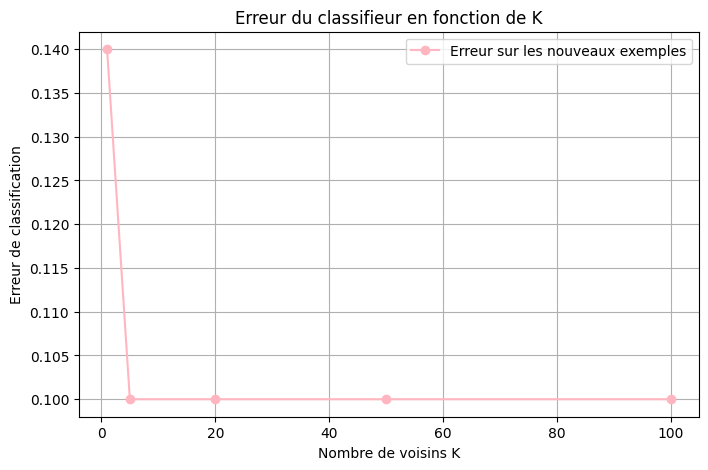

<b style="color:red"> Réponse :</b>  

<b style="color:red"> À vous de jouer :</b>  Pour les Gaussienne et le damier, choisissez un $K$ et présentez la matrice de confusion associée au classificateur K-voisins les plus proches que vous venez de construire (vous pouvez utiliser ``sklearn.metrics`` pour vous aider à obtenir une belle visualisation). Commentez. 

<b style="color:red"> Réponse :</b> 


```





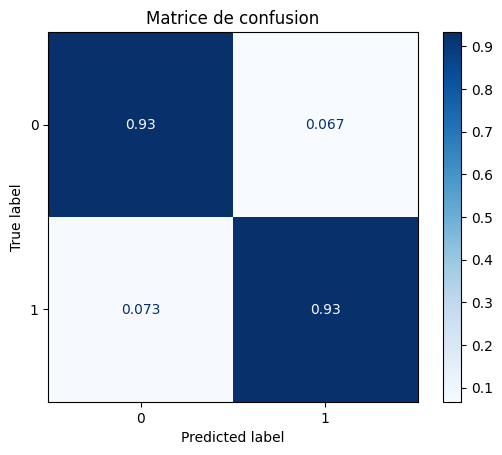

## Extension des K-plus proches voisins à un problème de régression <a id="part1sec4"></a>
### On ne connait pas $\mathcal{D}$ mais on peut simuler autant de données que l'on veut

Nous allons à présent étudier rapidement un problème de régression issu également d'une simulation de données. On considère la fonction de simulation **rand_reg_gauss** ci dessous. 

In [13]:
def rand_reg_gauss(n):
    
    X = np.random.rand(n) * 10  # n points entre 0 et 10
    y = X.squeeze() + np.random.normal(0,1,n)  # y = x + bruit

    return X, y

<b style="color:red"> À vous de jouer :</b>  Adaptez le code que vous venez de produire pour la classification pour construire un regresseur des K-plus priches voisisns. C'est à dire: 

- Générez 1000 couples $(x_i, y_i)$, qui serviront de référence pour le regresseur (jeu de données d'entraînement).  
- Générez 100 nouveaux couples (jeu de données de test). Pour chacun de ces points, comparez la prédiction faite par un le regresseur des $K$ plus proches voisins pour $K = 1$. Calculez ensuite l'erreur empirique sur le jeu de test en comparant la prédiction avec le vrai valeur du "label" de chaque point.  
- Répétez cette opération pour différentes valeurs de $K = 5, 20, 50, 100$ et tracez une courbe pour comparer les erreurs obtenues. Que remarquez-vous ?
- Enfin changez la fonction que vous avez utilisé comme indicateur de tendance centrale pour vos données (si vous utilisiez la moyenne, changez à la mediane ou à la moyenne tronquée et vide versa) et comparez les résultats. 

<b style="color:red"> Réponse :</b> 

```


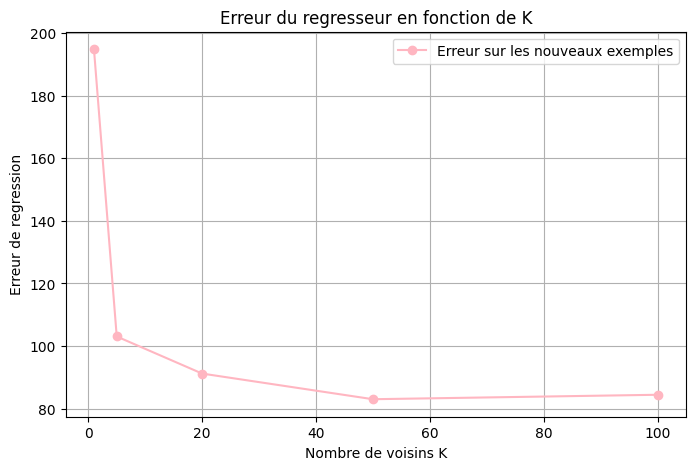

In [ ]:
def knn_regression(X, y, x_new, K, distance=euclidean_distance, agg="avg"):





    
    return 




# Les K-plus proches voisins sur des données réelles (digits avec sklearn) <a id="part2"></a>

Nous allons à présent nous autoriser à utiliser le package scikit learn pour étudier une base de donnée d'images: le jeu de données Digits. À l'instar de MNIST, le jeu de données de scikit-learn est un ensemble utilisé pour la reconnaissance de chiffres manuscrits. Il contient 1797 images, chacune représentant un chiffre entre 0 et 9 sous forme d'une matrice de 8x8 pixels en niveaux de gris, avec des valeurs comprises entre 0 et 16. Chaque image est accompagnée d'un label indiquant le chiffre qu'elle représente. Les données sont disponibles sous différentes formes : une version aplatie où chaque image est représentée par un vecteur de 64 caractéristiques, une version matricielle conservant le format 8x8, ainsi qu'un tableau contenant les étiquettes associées. Récupérons ces données à l'aide de la fonction ``load_digits()``. 

Shape of X: (1797, 64)
Shape of y: (1797,)


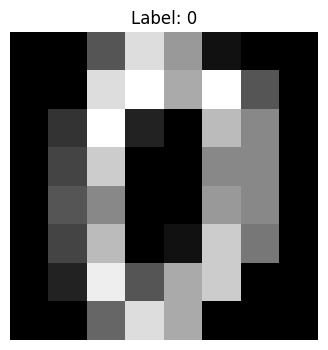

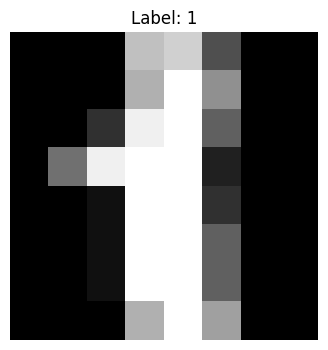

In [16]:
digits = load_digits()
X = digits.data 
y = digits.target

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

plt.figure(figsize=(4, 4))
plt.imshow(X[0, :].reshape(8, 8), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')

plt.figure(figsize=(4, 4))
plt.imshow(X[1, :].reshape(8, 8), cmap='gray')
plt.title(f"Label: {y[1]}")
plt.axis('off')
plt.show()

## Les 1-plus proches voisins avec sklearn <a id="part2sec1"></a>

Allez voir sur le site de [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) comment utiliser le module dédié aux $K$-plus proches voisins. 

<b style="color:red"> À vous de jouer: </b> Avant de lancer cet algorithme, quel prétraitement faut-il effectuer ? Pourquoi ? Quel est le taux d'erreur sur vos données d'apprentissage (i.e., la proportion d'erreurs faites par le classifieur) lorsque $K=1$ ? Et sur les données de test ? Pensez-vous qu'il faille conserver $K=1$ ?




<b style="color:red"> Réponse :</b>

```


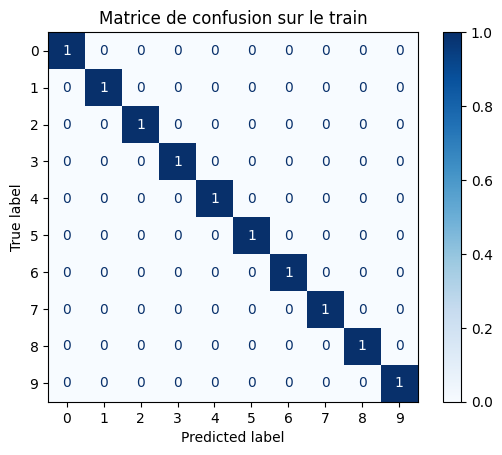

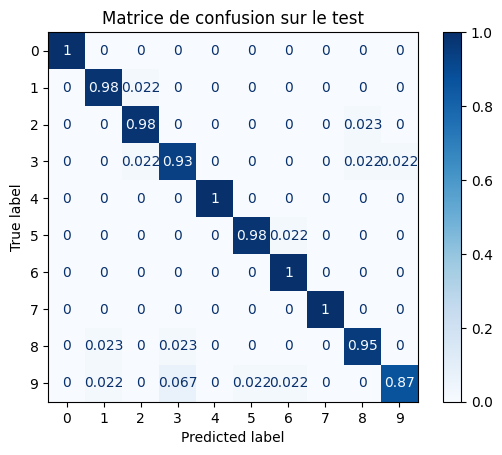

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

cm = confusion_matrix(y_train, knn.predict(X_train))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation par ligne

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matrice de confusion sur le train")
plt.show()

cm = confusion_matrix(y_test, knn.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation par ligne

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matrice de confusion sur le test")
plt.show()

## La cross validation par la méthode du leave one out <a id="part2sec2"></a>

Pour rappel, la cross-validation est une technique utilisée pour évaluer la performance d'un modèle en le testant sur différentes sous-parties de l'ensemble de données. L'idée est de diviser les données en plusieurs sous-ensembles, puis d'entraîner le modèle sur une partie de ces sous-ensembles et de le tester sur le reste. Cela permet d'obtenir une estimation plus fiable de la performance générale du modèle, réduisant ainsi le risque de surapprentissage. En particulier, l'algorithme du leave-one-out (LOO) consiste à utiliser un seul échantillon comme ensemble de test et tous les autres comme ensemble d'entraînement, répétant ce processus pour chaque échantillon du jeu de données.

<b style="color:red"> À vous de jouer: </b> En utilisant toutes les données et les fonctions associées de sklearn, telles que ``KNeighborsClassifier`` pour l'algorithme des $K$-plus proches voisins et ``LeaveOneOut()`` pour effectuer la cross-validation, vous pouvez calculer et tracer la courbe du taux d'erreur pour les différentes valeurs de $K =1, 3, 5, 7, 9, 13, 15, 17$. Pour chaque valeur de $K$, l'algorithme sera évalué sur un ensemble de validation distinct à chaque itération (en utilisant l'approche LOO).

<b style="color:red"> Réponse: </b>

```


## Implementation accélérée avec une ACP <a id="part2sec3"></a>

En fonction de votre machine, le code précedent à peut etre is un peu de temps à tourner. Dans le cadre du KNN, l'ACP peut améliorer la performance du modèle en réduisant le bruit et en éliminant les dimensions redondantes. Cela peut rendre le modèle plus rapide et plus efficace. Cependant, un inconvénient majeur de l'ACP est qu'elle peut entraîner une perte d'information si trop de composantes sont supprimées, ou si les composantes principales ne capturent pas bien la structure des données pour la tâche de classification. 

<b style="color:red"> À vous de jouer: </b> Implémentez la même approche de validation croisée leave-one-out pour le KNN, mais cette fois en utilisant une réduction de dimensionnalité préalable via l'ACP, en testant plusieurs niveaux d'inertie expliquée (par exemple, $75\%, 85\%, 95\%, 99\%$). Testez l'effet de cette réduction sur le taux d'erreur pour différentes valeurs de $K = 1, 3, 5, 7, 9, 13, 15, 17$ et comparez les résultats avec ceux obtenus sans ACP. Comparez également les différentes valeurs d'inertie expliquée pour voir comment cela influence les performances du modèle.



<b style="color:red"> Réponse: </b>

```


# Quelques exercices <a id="part3"></a>

# Exercice 1 <a id="part3sec1"></a>

Reprenez le jeu de donnée MNIST binaire que nous avions utilisé pour le TP sur L'ACP. Essayez de reproduire une courbe de cross-validation (pas forcement leave on out) pour MNIST. Commentez. 

# Exercice 2

Vous avez à disposition sur moodle un fichier **pokemon.csv** dans lequel vous avez environ 400 Pokemon répartis selon 18 types (oui encore une ref de vieux). Je vous donne un nouveau Pokemon, nommé Hippodocus, qui possède les caractéristiques suivantes:

- Points de vie = 108
- Attaque=112
- Défense = 118
- Vitesse= 47

En utilisant la méthode de votre choix (ACP ou pas/choix des distances/etc.), attribuez a ce pokémon un type parmi ceux déjà existant dans la base de données. Faites varier vos choix, le résultat reste-il stable ? Observer la table "pokemon", surtout les effectifs des différents types. Commentez. 


# Exercice 3

Dans cet exercice, nous allons implémenter l’algorithme de régression par *K-plus proches voisins* (K-NN) afin de prédire le prix de vente des maisons en utilisant le jeu de données *House Prices* disponible sur Kaggle. L’objectif est de comprendre l’influence du paramètre $K$ sur la qualité des prédictions. Nous porterons une attention particulière au choix des variables explicatives et à la métrique de distance utilisée pour le calcul des voisins. Téléchargez le jeu de données *House Prices* depuis [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

- Prétraitez les données: sélectionnez les variables pertinentes, gérez les valeurs manquantes et normalisez les données si nécessaire.
- Implémentez l’algorithme K-NN pour la régression en utilisant *scikit-learn*.
- Testez les différentes valeurs de $K$ et analysez leur impact sur la performance du modèle.
- Étudiez l’effet du choix de la métrique de distance (euclidienne vs Manhattan) sur la qualité des prédictions.
- Représentez graphiquement les prédictions obtenues par K-NN en fonction des vraies valeurs.
